# Diffusion Models as Stochastic Quantization in Lattice Field Theory


## Goals
It's a note book for demonstrating how the Diffusiom Models can be applied into the scalar phi-4 theory.

The contents of this notebook are mainly based on the following paper: 

Diffusion Models as Stochastic Quantization in Lattice Field Theory, L Wang, G Aarts, K Zhou, [arXiv:2309.17082[hep-lat]](https://arxiv.org/abs/2309.17082)

In [1]:
import numpy as np

import os
folder_path1 = 'data'
folder_path2 = 'figures'
folder_path3 = 'models'

if not os.path.exists(folder_path1):
    os.makedirs(folder_path1)
if not os.path.exists(folder_path2):
    os.makedirs(folder_path2)
if not os.path.exists(folder_path3):
    os.makedirs(folder_path3)

## 1. Generating Field Configurations

We consider a real scalar field in $d$-Euclidean dimensions with the action, 

\begin{equation}
S_E = \int \text{d}^{d}x\left( \frac{1}{2}\sum_{\mu=1}^d\left(\partial_\mu\phi_0\right)^2 + \frac{1}{2} m_0^2\phi_0^2 + \frac{\lambda_0}{4!}\phi_0^4 \right),
\end{equation}

where the subscript specifies bare quantities, including mass $m_0$, coupling $\lambda_0$, and field $\phi_0(x)$. Discretising the derivative on a lattice with lattice spacing $a$ in all directions,$\partial_\mu\phi_0(x)=[\phi_0(x+a\hat\mu)-\phi(x)]/a$, with $\hat{\mu}$ the unit vector along the $\mu-$ direction, and redefining the field and parameters to yield dimensionless combinations, gives the lattice action

\begin{equation}
S_E = \sum_x \left[  -2\kappa \sum_{\mu = 1}^d\phi(x)\phi(x+\hat{\mu}) + (1-2\lambda)\phi^2(x) + \lambda\phi^4(x) \right],
\end{equation}

where $\kappa$ is the hopping parameter, related to the bare mass parameter via

\begin{equation}
     (am_0)^2 = \frac{1-2\lambda}{\kappa} - 2d,
\end{equation}

and $\lambda=a^{4-d}\kappa^2\lambda_0/6$ denotes the dimensionless coupling constant describing field interactions. Both parameters are positive. The field has been rescaled according to $a^{d/2-1}\phi_0=(2\kappa)^{1/2}\phi$.

### 1.1 MCMC

In [2]:
from mc import get_action, get_drift, get_hamiltonian, hmc
L = 16
k = 0.27
# k = 0.21
l = 0.022

# superparameters for generating configurations
chains = 1024
nk = 10

In [3]:
import copy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm 

filename = 'data/cfgs_L{}_k{}_l{}_{}k.npy'.format(L,k,l,nk)

def runhmc(chains):
    local_cfgs = []
    local_acc = []
    for chain_idx in tqdm(range(chains), desc="Chain Progress"):
        phi = np.random.randn(L,L)
        S = get_action(phi, k, l)
        for i in range(all_steps):
            phi, S, accepted = hmc(phi, S, k, l)
            local_acc.append(accepted)
            if i % eq_step == 0 and i > therm_step:
                local_cfgs.append(copy.deepcopy(phi))
    return local_cfgs

if os.path.exists(filename):
    print('load from file') 
    cfgs = np.load(filename,allow_pickle=True)

else:
    print('generating new cfgs')
    therm_step = 100
    eq_step = 64
    all_steps = (therm_step + eq_step)
                
    # prepare training data-set
    chainlist = list(chains for i in range(nk))
    max_workers = 0  # Set this variable to control the number of workers

    if max_workers > 1:
        # Use multiprocessing when more than 1 worker is specified
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(runhmc, chainlist))
    else:
        # Execute serially without multiprocessing
        results = [runhmc(chains) for i in range(nk)]
        

    # Accumulating and reshaping results
    all_cfgs = [cfg for sublist in results for cfg in sublist]
    cfgs = np.array(all_cfgs).reshape(-1, L, L)
    print(cfgs.shape)

    np.save(filename, cfgs)

load from file


### 1.2 Langevin Dynamics

In [5]:
from langevin import Lattice
d = 2
L = 16
# k = 0.5
k = 0.27
l = 0.022

# superparameters for generating configurations
chains = 1024
nk = 1
therm_step =  500 # thermalization time
lattice = Lattice(L, d, k, l)

In [6]:
from tqdm import tqdm 

filename = 'data/langevin_cfgs_L{}_k{}_l{}_{}k.npy'.format(L,k,l,nk)


if os.path.exists(filename):
    print('load langevin configs from file') 
    cfgs_langevin = np.load(filename)

else:
    print("burn in...\n")
    for i in tqdm(range(therm_step)):
        lattice.phi = np.random.randn(*[L for _ in range(d)]) # starting from a random config
        # lattice.phi = ini_phi # starting from a exising random config
        
        for j in range(therm_step - 1):
            lattice.langevin()


    print("\nrecording...\n")

    cfgs_langevin = []
    n_accepted = 0
    n_skip = 10
    ntotal = chains * nk * n_skip

    for i in tqdm(range(ntotal)):
        n_accepted += lattice.langevin()

        if i % n_skip == 0:
            cfgs_langevin.append(copy.deepcopy(lattice.phi))

    cfgs_langevin = np.array(cfgs_langevin)
    print("\ndone.")

    print("accept rate:", n_accepted / ntotal)

    print(cfgs_langevin.shape)
    np.save(filename, cfgs_langevin)

burn in...



100%|██████████| 500/500 [00:10<00:00, 47.56it/s]



recording...



100%|██████████| 10240/10240 [00:00<00:00, 23247.22it/s]


done.
accept rate: 1.0
(1024, 32, 32)


### 1.3 Observables

In [4]:
# cfgs = cfgs_langevin
from observable import get_mag, get_abs_mag, get_chi2

mag_mean, mag_err = get_mag(cfgs)
print("M =", mag_mean, "+/-", mag_err)

mag_abs_mean, mag_abs_err = get_abs_mag(cfgs)
print("|M| =", mag_abs_mean, "+/-", mag_abs_err)

chi2_mean, chi2_err = get_chi2(cfgs)
print("chi2 =", chi2_mean, "+/-", chi2_err)

M = 0.030000055741617505 +/- 0.007292754145823734
|M| = 0.6593394273994033 +/- 0.0032884742802843396
chi2 = 139.40573930977394 +/- 1.086337214719185


## 2. Diffusion Models

### 2.1 preparations

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

if torch.cuda.is_available():
  device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_tensor_type(torch.DoubleTensor)
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 4090


c:\Users\angus\anaconda3\Lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


#### 2.1.1 normalization

In [6]:
from norm import norm, renorm

cfgs_nm,cfgs_min,cfgs_max = norm(cfgs)

nm = 1

# configs = torch.from_numpy(cfgs).unsqueeze(1).to(device) # torch tensor
# configs = torch.from_numpy(cfgs).unsqueeze(1).float().to(device) # torch tensor

if nm == 1:
    configs = torch.from_numpy(cfgs_nm).unsqueeze(1).float().to(device) # torch tensor
else:
    configs = torch.from_numpy(cfgs).unsqueeze(1).float().to(device) # torch tensor

configs.shape

torch.Size([10240, 1, 16, 16])

#### 2.1.2 data set 

In [7]:
from torch.utils.data import Dataset, DataLoader,TensorDataset

n_epochs =   250#@param {'type':'integer'}
## size of a mini-batch
batch_size =  64 #@param {'type':'integer'}
## learning rate
lr=1e-3 #@param {'type':'number'}

nk_train = 8
num_test = 1024
num_train = nk_train*1024

dataset = TensorDataset(configs[:num_train], configs[:num_train])
data_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True, generator=torch.Generator(device))#

testing_dataset = TensorDataset(configs[:num_test], configs[:num_test])
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, generator=torch.Generator(device))#, generator=torch.Generator(device)

#### 2.1.3 stochastic differential equations

In [8]:
import functools
from sde import marginal_prob_std, diffusion_coeff

sigma =  25.0#@param {'type':'number'} default = 25
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma, device=device)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma, device=device)

### 2.2 Building ScoreNet

In [9]:
import torch
import tqdm
from torch.optim import Adam
from loss import loss_fn
import torchvision.transforms as transforms
from unet import GaussianFourierProjection,Dense,ScoreNet

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

### 2.3 Training

In [ ]:
#@title Training (double click to expand or collapse)
n_epochs = 250
optimizer = Adam(score_model.parameters(), lr=lr)
tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in data_loader:
    x = x.to(device)    
    loss = loss_fn(score_model, x, marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()    
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'models/ckpt_L{}_k{}_l{}_num{}_nm{}.pth'.format(L,k,l,num_train,nm))

### 2.4 Sampling

In [11]:
from sampler import Euler_Maruyama_sampler, pc_sampler, ode_sampler
## The number of sampling steps.
num_steps =  200#@param {'type':'integer'}

## The The signal-to-noise ratio of the Langevin MCMC step.
signal_to_noise_ratio = 0.16 #@param {'type':'number'}

## The error tolerance for the black-box ODE solver
error_tolerance = 1e-5 #@param {'type': 'number'}

In [12]:
#@title Sampling

## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('models/ckpt_L{}_k{}_l{}_num{}_nm{}.pth'.format(L,k,l,num_train,nm), map_location=device)
score_model.load_state_dict(ckpt)

num_sample = 1024 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

# del samples
torch.cuda.empty_cache()

## Generate samples using the specified sampler.
samples,_ = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  batch_size = num_sample, 
                  num_steps = num_steps,
                  device=device, L =L)


c:\Users\angus\WorkSpace\DM\DMasSQ_open\sde.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\angus\WorkSpace\DM\DMasSQ_open\sde.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 200/200 [00:04<00:00, 48.29it/s]


### 2.5 Evaluation

In [13]:
from observable import grab, mag, abs_mag, get_UL
# samples_re = samples
samples_re = renorm(samples,cfgs_min,cfgs_max)

filename = 'data/generated_cfgs_L{}_k{}_l{}_{}k.npy'.format(L,k,l,nk)
if os.path.exists(filename):
  cfgs_df = np.load(filename)
else:
  cfgs_df = grab(samples_re)
  cfgs_df = cfgs_df.squeeze(1)
  np.save(filename, cfgs_df)

Mall_df = mag(cfgs_df) # magnetization of DM generated configurations
Mall = mag(cfgs) # magnetization of prepared configurations
print(Mall.mean())
print(Mall_df.mean())

0.030000055741617505
0.32521194


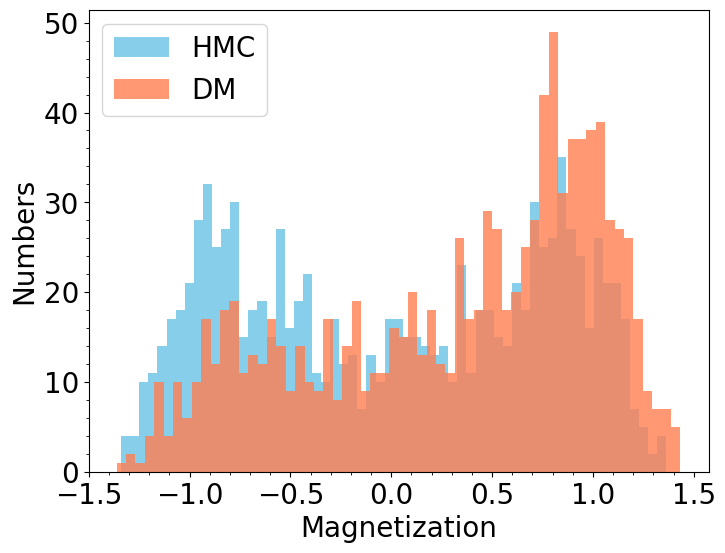

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.rc('font', size=20)
plt.hist(Mall[-num_sample:],bins=60,alpha= 1.,label = 'HMC',density=False, color= 'skyblue')
plt.hist(Mall_df,bins=60,alpha = 0.8,label = 'DM',density=False,color='coral')
plt.xlabel('Magnetization')
plt.ylabel('Numbers')

plt.legend()
plt.minorticks_on()

figurename = 'figures/mag_L{}_k{}_l{}_{}k.pdf'.format(L,k,l,nk)

if os.path.exists(figurename):
  pass
else:
  plt.savefig(figurename, dpi=300, bbox_inches='tight')

plt.show()

In [15]:
testing_sample = cfgs_df
M, M_err = get_mag(testing_sample)
M_abs, M_abs_err = get_abs_mag(testing_sample)
chi2, chi2_err = get_chi2(testing_sample)
UL, UL_err = get_UL(testing_sample)

print("M = %.4f +/- %.4f" % (M, M_err))
print("|M| = %.4f +/- %.4f" % (M_abs, M_abs_err))
print("chi2 = %.4f +/- %.4f" % (chi2, chi2_err))
print("UL = %.4f +/- %.4f" % (UL, UL_err))

M = 0.3252 +/- 0.0218
|M| = 0.6875 +/- 0.0109
chi2 = 124.9001 +/- 3.7686
UL = 0.4570 +/- 0.0218


### 2.6 Visualization

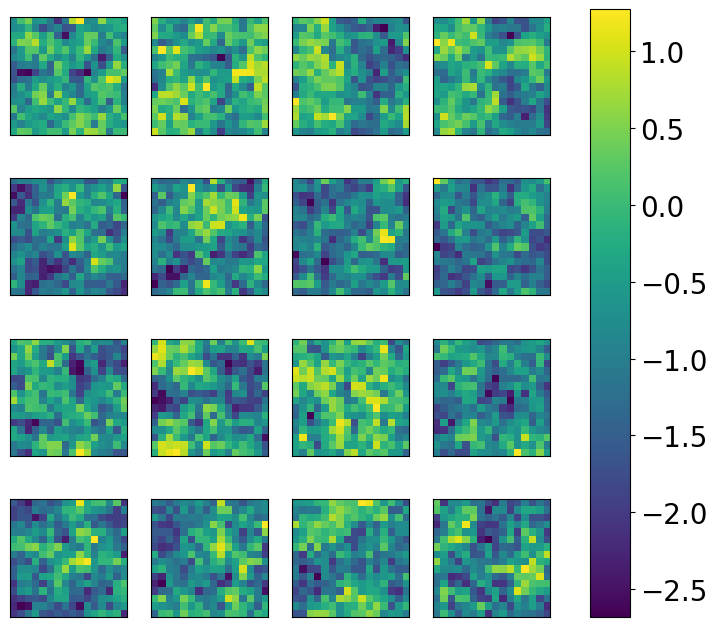

In [17]:
from plot_sample import show_images
show_images(samples_re)

## 3. Compute Likelihood

Here we refer to the work, "Song, Y., Sohl-Dickstein, J., Kingma, D.P., Kumar, A., Ermon, S., Poole, B., 2021. Score-based generative modeling through stochastic differential equations, in: ICLR 2021".


A by-product of the probability flow ODE formulation is likelihood computation. Suppose we have a differentiable one-to-one mapping $\mathbf{h}$ that transforms a data sample $\mathbf{x} \sim p_0$ to a prior distribution $\mathbf{h}(\mathbf{x}) \sim p_T$. We can compute the likelihood of $p_0(\mathbf{x})$ via the following [change-of-variable formula](https://en.wikipedia.org/wiki/Probability_density_function#Function_of_random_variables_and_change_of_variables_in_the_probability_density_function)
\begin{align*}
p_0(\mathbf{x}) = p_T(\mathbf{h}(\mathbf{x})) |\operatorname{det}(J_\mathbf{h}(\mathbf{x}))|,
\end{align*}
where $J_\mathbf{h}(\mathbf{x})$ represents the Jacobian of the mapping $\mathbf{h}$, and we assume it is efficient to evaluate the likelihood of the prior distribution $p_T$. 

The trajectories of an ODE also define a one-to-one mapping from $\mathbf{x}(0)$ to $\mathbf{x}(T)$. For ODEs of the form
\begin{align*}
d \mathbf{x} = \mathbf{f}(\mathbf{x}, t) dt,
\end{align*}
there exists an [instantaneous change-of-variable formula](https://arxiv.org/abs/1806.07366) that connects the probability of $p_0(\mathbf{x})$ and $p_1(\mathbf{x})$, given by
\begin{align*}
p_0 (\mathbf{x}(0)) = e^{\int_0^1 \operatorname{div} \mathbf{f}(\mathbf{x}(t), t) d t} p_1(\mathbf{x}(1)),
\end{align*}
where $\operatorname{div}$ denotes the divergence function (trace of Jacobian). 

In practice, this divergence function can be hard to evaluate for general vector-valued function $\mathbf{f}$, but we can use an unbiased estimator, named [Skilling-Hutchinson estimator](http://blog.shakirm.com/2015/09/machine-learning-trick-of-the-day-3-hutchinsons-trick/), to approximate the trace. Let $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$. The Skilling-Hutchinson estimator is based on the fact that
\begin{align*}
\operatorname{div} \mathbf{f}(\mathbf{x}) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_\mathbf{f}(\mathbf{x}) \boldsymbol\epsilon].
\end{align*}
Therefore, we can simply sample a random vector $\boldsymbol \epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$, and then use $\boldsymbol \epsilon^\intercal J_\mathbf{f}(\mathbf{x}) \boldsymbol \epsilon$ to estimate the divergence of $\mathbf{f}(\mathbf{x})$. This estimator only requires computing the Jacobian-vector product $J_\mathbf{f}(\mathbf{x})\boldsymbol \epsilon$, which is typically efficient.

As a result, for our probability flow ODE, we can compute the (log) data likelihood with the following
\begin{align*}
\log p_0(\mathbf{x}(0)) = \log p_1(\mathbf{x}(1)) -\frac{1}{2}\int_0^1 \frac{d[\sigma^2(t)]}{dt} \operatorname{div} s_\theta(\mathbf{x}(t), t) dt.
\end{align*}
With the Skilling-Hutchinson estimator, we can compute the divergence via
\begin{align*}
\operatorname{div} s_\theta(\mathbf{x}(t), t) = \mathbb{E}_{\boldsymbol\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})}[\boldsymbol\epsilon^\intercal  J_{s_\theta}(\mathbf{x}(t), t) \boldsymbol\epsilon].
\end{align*}
Afterwards, we can compute the integral with numerical integrators. This gives us an unbiased estimate to the true data likelihood, and we can make it more and more accurate when we run it multiple times and take the average. The numerical integrator requires $\mathbf{x}(t)$ as a function of $t$, which can be obtained by the probability flow ODE sampler.

In [18]:
from likelihood import ode_likelihood

## Load the pre-trained checkpoint from disk.
# device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('models/ckpt_L{}_k{}_l{}_num{}_nm{}.pth'.format(L,k,l,num_train,nm), map_location=device)
score_model.load_state_dict(ckpt)

sample_size = 256
generated = samples[:sample_size]

_,logp, bpd = ode_likelihood(generated, score_model, marginal_prob_std_fn,
                            diffusion_coeff_fn, batch_size = sample_size, device= device) # eps=1e-5

c:\Users\angus\WorkSpace\DM\DMasSQ_open\sde.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


In [ ]:
dmmc_filename_logq = 'data/dmmc_logq_L{}_k{}_l{}_num{}_nm{}.npy'.format(L,k,l,num_train,nm)
if os.path.exists(dmmc_filename_logq):
    pass
else:
    np.save('data/dmmc_logq_L{}_k{}_l{}_num{}_nm{}.npy'.format(L,k,l,num_train,nm),grab(logp))
    np.save('data/dmmc_cfgs_L{}_k{}_l{}_num{}_nm{}.npy'.format(L,k,l,num_train,nm),grab(generated[:,0,:,:]))

In [ ]:
def action(phi: np.ndarray, k, l):
    return np.sum(-2 * k * phi * (np.roll(phi, 1, 1) + np.roll(phi, 1, 2))
                  + (1 - 2 * l) * phi**2 + l * phi**4,axis=(1,2))


Sall_df = grab(-logp)

generated_re = grab(renorm(generated,cfgs_min,cfgs_max))
# generated_re = grab(generated)


Sall_real = action(generated_re[:,0],k,l)

plt.figure(figsize=(6,5))
plt.rc('font', size=15)

plt.hist2d(Sall_df,Sall_real, bins = 20, cmap='Greens')

fit_b = np.mean(Sall_real) - np.mean(Sall_df)
xs = np.linspace(np.min(Sall_df),np.max(Sall_df), num=100, endpoint=True)
plt.plot(xs, xs + fit_b, ':', color='black',linewidth = 2, label='slope 1 fit') 

plt.ylabel('$S(\phi)$')
plt.xlabel('$S_{eff}\equiv -\log q(\phi)$')
plt.savefig('figures/action_k{}.pdf'.format(k),dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# R^2 coefficient
corr_matrix = np.corrcoef(Sall_real, Sall_df)
corr = corr_matrix[0,1]
R_sq = corr**2
print(R_sq)